# Bitcoin Price Prediction - ARIMA 
---
BTC price prediction using ARIMA (Auto Regressive Integrated Moving Average)

Overview:

Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed public adoption of bitcoin and continue to grow. Included here is historical bitcoin market data at daily intervals.

## <font color=#FFBD33>0. Get BTC historical data from CoinGecko API</font>

In [184]:
# Import library
import datetime as dt
import pandas as pd #type: ignore
from dotenv import load_dotenv #type: ignore
from pandas import json_normalize #type: ignore
from pycoingecko import CoinGeckoAPI

In [185]:
# CoinGecko client API
cg = CoinGeckoAPI()

# get BTC historical data from API
btc_hist= cg.get_coin_market_chart_by_id(id="bitcoin", vs_currency="usd", days="max")
btc_df  = pd.DataFrame(data=btc_hist["prices"], columns=["timestamp", "price"])

#save dataframe into csv
btc_df.to_csv('btc_hist.csv', encoding='utf-8', index=False)
btc_df.head()

,timestamp,price
0,1367107200000,135.30
1,1367193600000,141.96
2,1367280000000,135.30
3,1367366400000,117.00
4,1367452800000,103.43


## <font color=#FFBD33>1. Load Dataset</font>

### <font color=#DBFF33>a) Import Library </font>

In [186]:
# Import libraries
import warnings
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib as mpl
import statsmodels.api as sm
from itertools import product
from datetime import datetime
import matplotlib.pylab as plt
plt.style.use('seaborn-poster')
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX

### <font color=#DBFF33>b) Load & Check Dataset </font>

In [187]:
# Load dataset btc_history
df = pd.read_csv('btc_hist.csv', sep=',')
print("Number of datapoints:", len(df))
df.head()

Number of datapoints: 3507


,timestamp,price
0,1367107200000,135.30
1,1367193600000,141.96
2,1367280000000,135.30
3,1367366400000,117.00
4,1367452800000,103.43


In [188]:
#describe dataset
df.describe()

,timestamp,price
count,3.507000e+03,3507.000000
mean,1.518723e+12,11046.238827
std,8.750627e+10,15672.609277
min,1.367107e+12,67.809000
25%,1.443010e+12,480.422500
50%,1.518739e+12,4632.462331
75%,1.594469e+12,11418.383306
max,1.670191e+12,67617.015545


## <font color=#FFBD33>2. EDA </font>

### <font color=#DBFF33>a) Change Unix timestamp to datetime </font>

In [189]:
# Unix-time to datetime
df["timestamp"] = df["timestamp"].apply(lambda x: dt.datetime.fromtimestamp(x / 1000))
df.head()

,timestamp,price
0,2013-04-28 07:00:00,135.30
1,2013-04-29 07:00:00,141.96
2,2013-04-30 07:00:00,135.30
3,2013-05-01 07:00:00,117.00
4,2013-05-02 07:00:00,103.43


In [190]:
# Resampling to daily frequency
df.index = df.timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

### <font color=#DBFF33>b) Visualize BTC History </font>

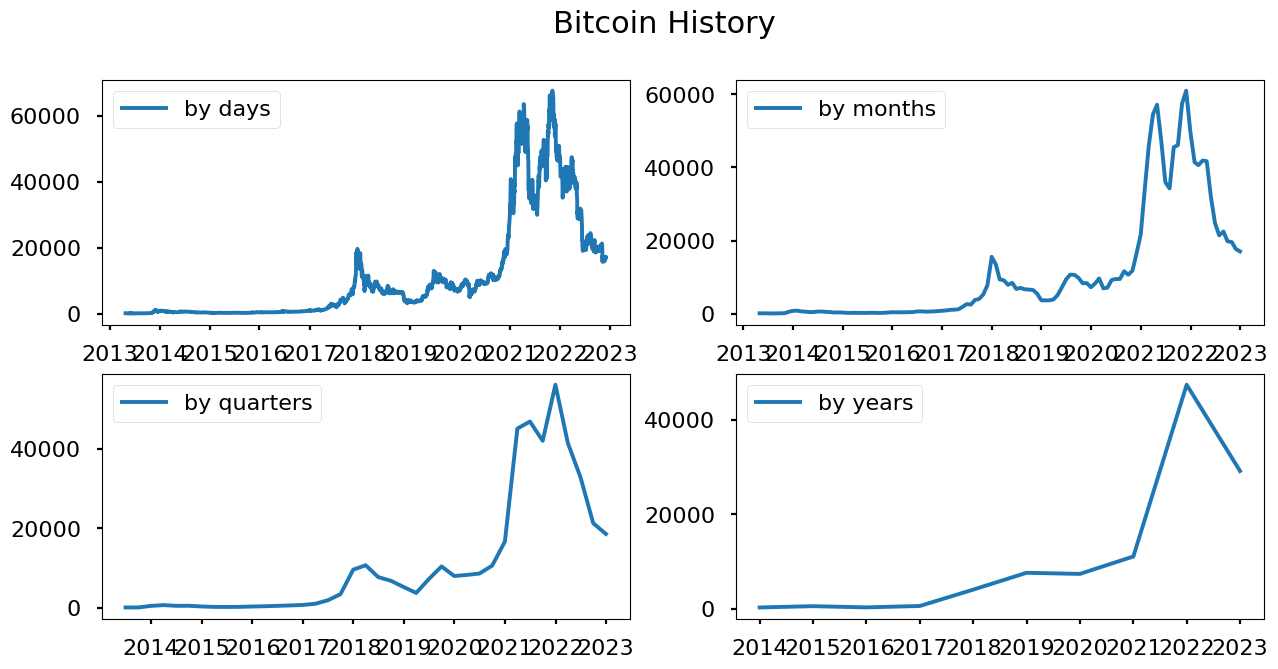

In [191]:
# Plots
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin History', fontsize=22)

plt.subplot(221)
plt.plot(df.price, '-', label='by days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.price, '-', label='by months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.price, '-', label='by quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.price, '-', label='by years')
plt.legend()
plt.show()

## <font color=#FFBD33>3. Stationarity Check</font>

dickey fuller test: p=0.475468


<Figure size 1500x700 with 0 Axes>

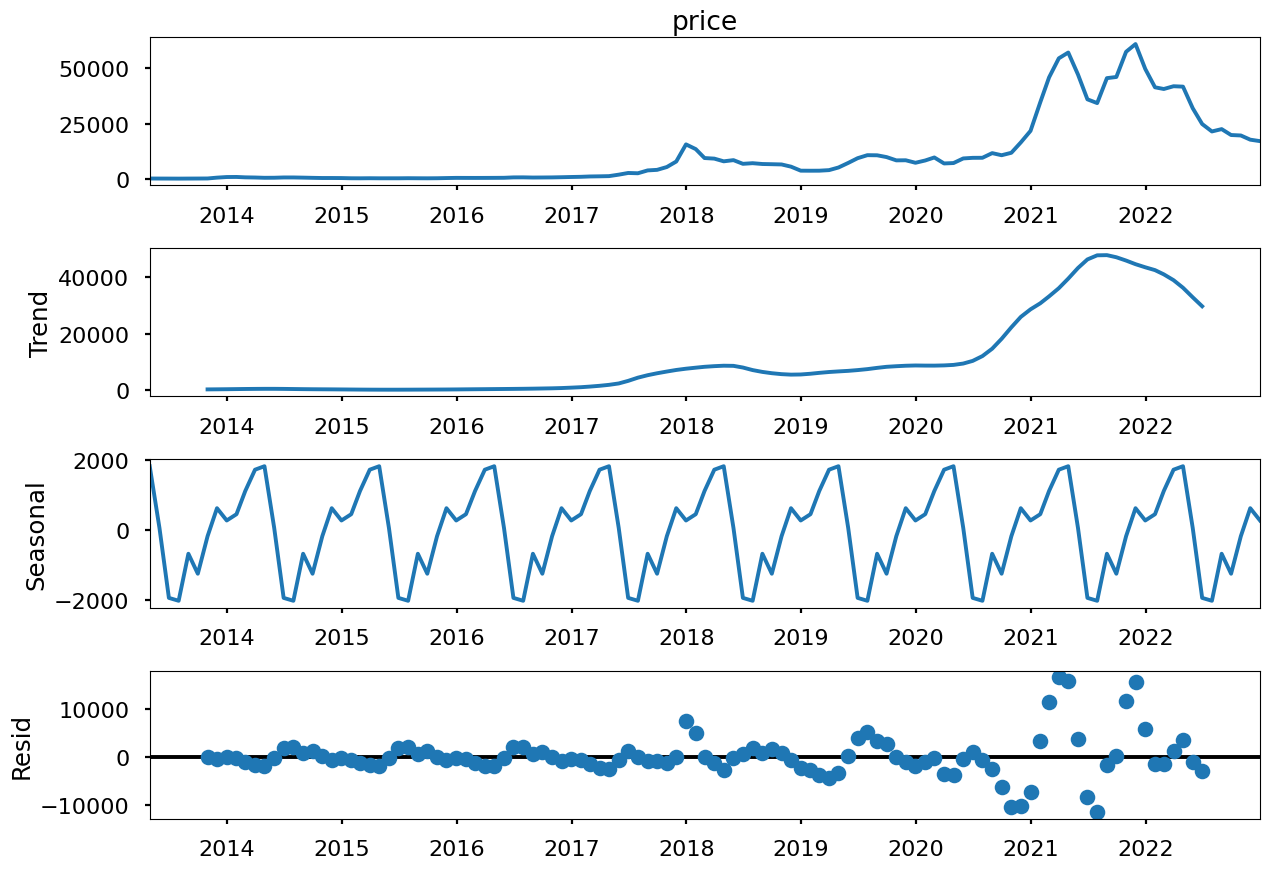

In [192]:
# Stationarity check and STL-decomposition of the series
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.price).plot()
print("dickey fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.price)[1])
plt.show()

The series are not stationary.

## <font color=#FFBD33>4. Box-Cox Transformations</font>

In [193]:
# Box-Cox Transformations
df_month['price_box'], lmbda = stats.boxcox(df_month.price)
print("dickey fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.price)[1])

dickey fuller test: p=0.475468


The series are not stationary.

## <font color=#FFBD33>5. Seasonal Differentiation</font>

In [194]:
# Seasonal differentiation
df_month['price_box_diff'] = df_month.price_box - df_month.price_box.shift(12)
print("dickey fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.price_box_diff[12:])[1])

dickey fuller test: p=0.390374


The series are not stationary.

## <font color=#FFBD33>6. Regular Differentiation</font>

dickey fuller test: p=0.000029


<Figure size 1500x700 with 0 Axes>

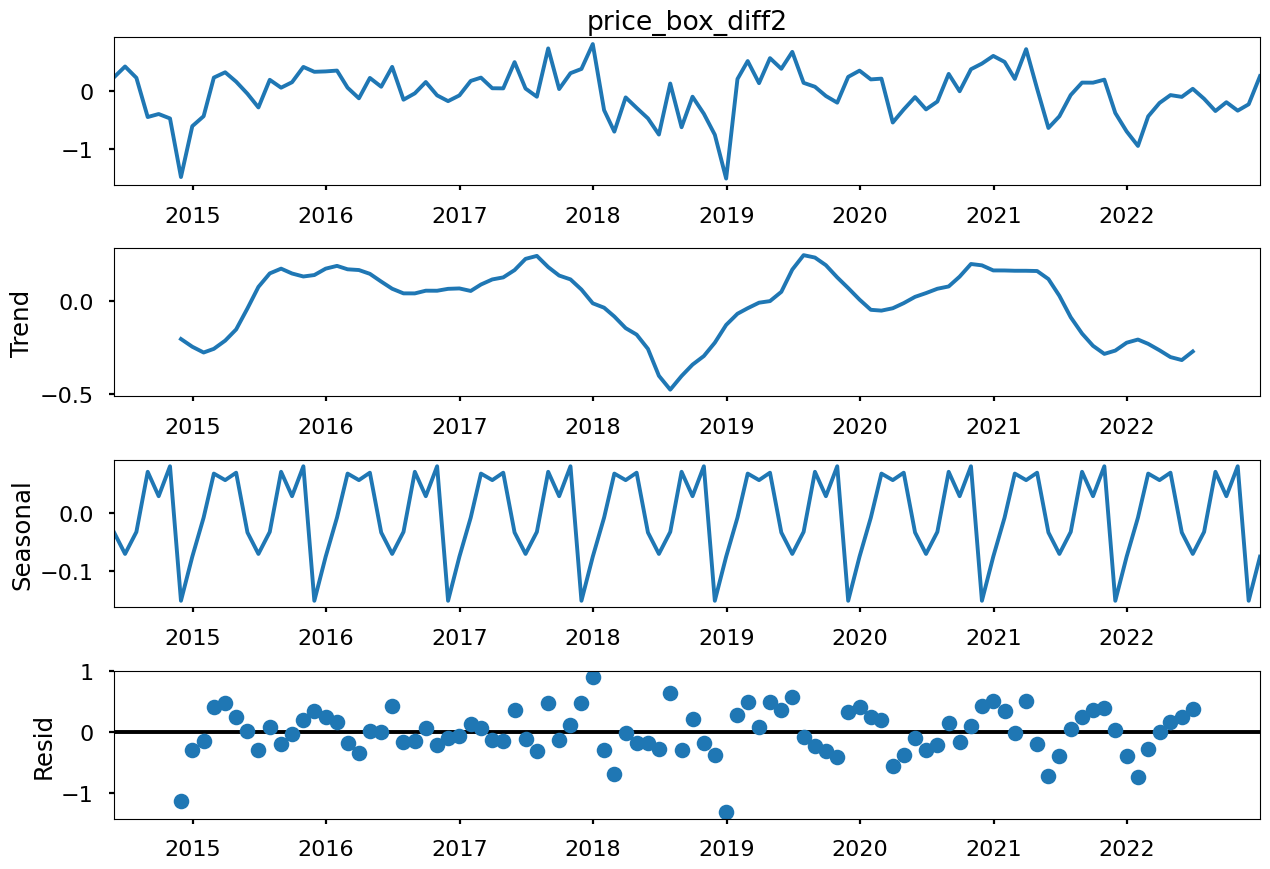

In [195]:
# Regular differentiation
df_month['price_box_diff2'] = df_month.price_box_diff - df_month.price_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.price_box_diff2[13:]).plot()   
print("dickey fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.price_box_diff2[13:])[1])

plt.show()

Now the series are stationary.

## <font color=#FFBD33>7. Model Selection & Prediction</font>

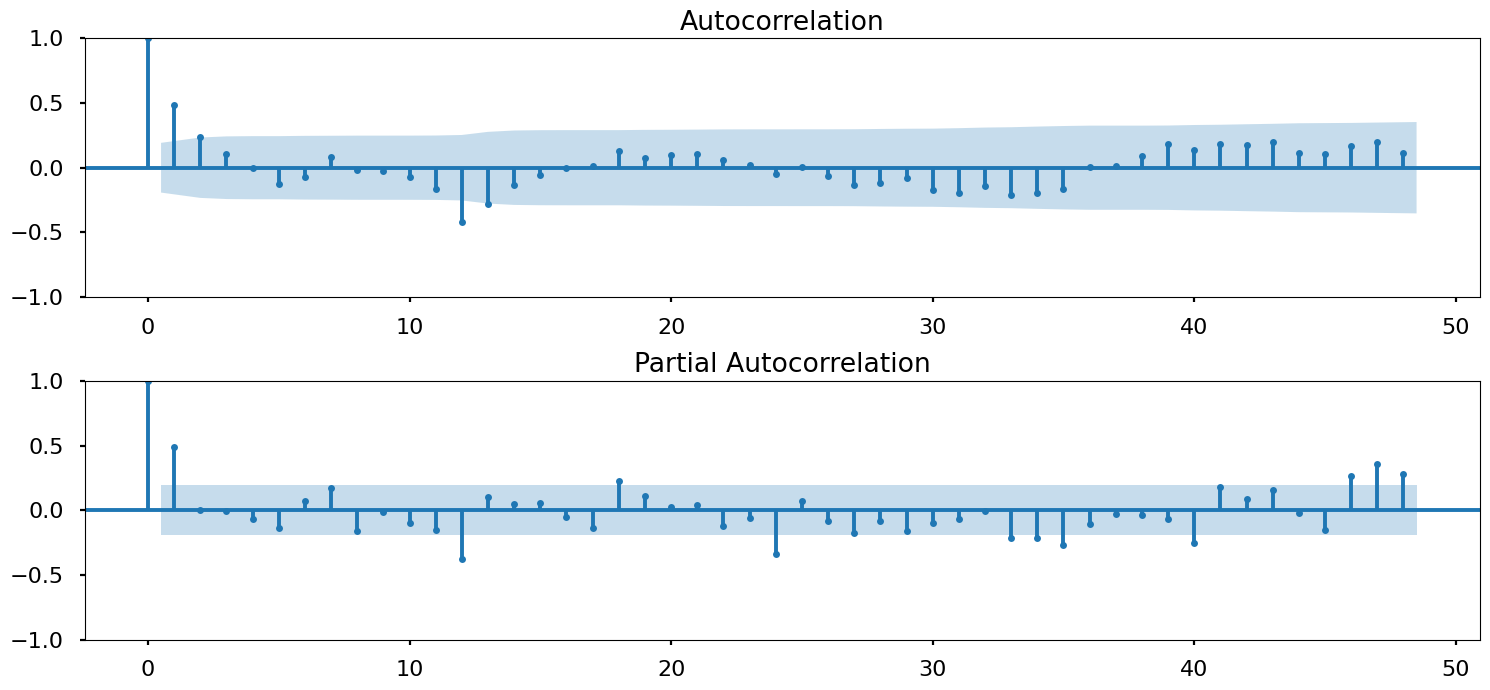

In [196]:
# Initial approximation of parameters using autocorrelation and partial autocorrelation plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.price_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.price_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

### <font color=#DBFF33>a) Model 1 </font>

In [208]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model selection
results1 = []
best_aic1 = float("inf")
warnings.filterwarnings('ignore')
for param1 in parameters_list:
    try:
        model1 = SARIMAX(df_month.price_box, order=(param1[0], d, param1[1])).fit(disp=-1)
    except ValueError:
        print('wrong parameter:', param1)
        continue
    aic1 = model1.aic
    if aic1 < best_aic1:
        best_model1 = model1
        best_aic1 = aic1
        best_param1 = param1
    results1.append([param1, model1.aic])

In [209]:
# best models 1
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())
print(best_model1.summary())
print("dickey fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model1.resid[13:])[1])

  parameters        aic
3     (1, 0)  31.858684
1     (0, 1)  32.946670
4     (1, 1)  33.509168
6     (2, 0)  33.576876
7     (2, 1)  33.656555
                               SARIMAX Results                                
Dep. Variable:              price_box   No. Observations:                  117
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -13.929
Date:                Mon, 05 Dec 2022   AIC                             31.859
Time:                        05:00:27   BIC                             37.366
Sample:                    04-30-2013   HQIC                            34.094
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4173      0.082      5.098      0.000       0.257

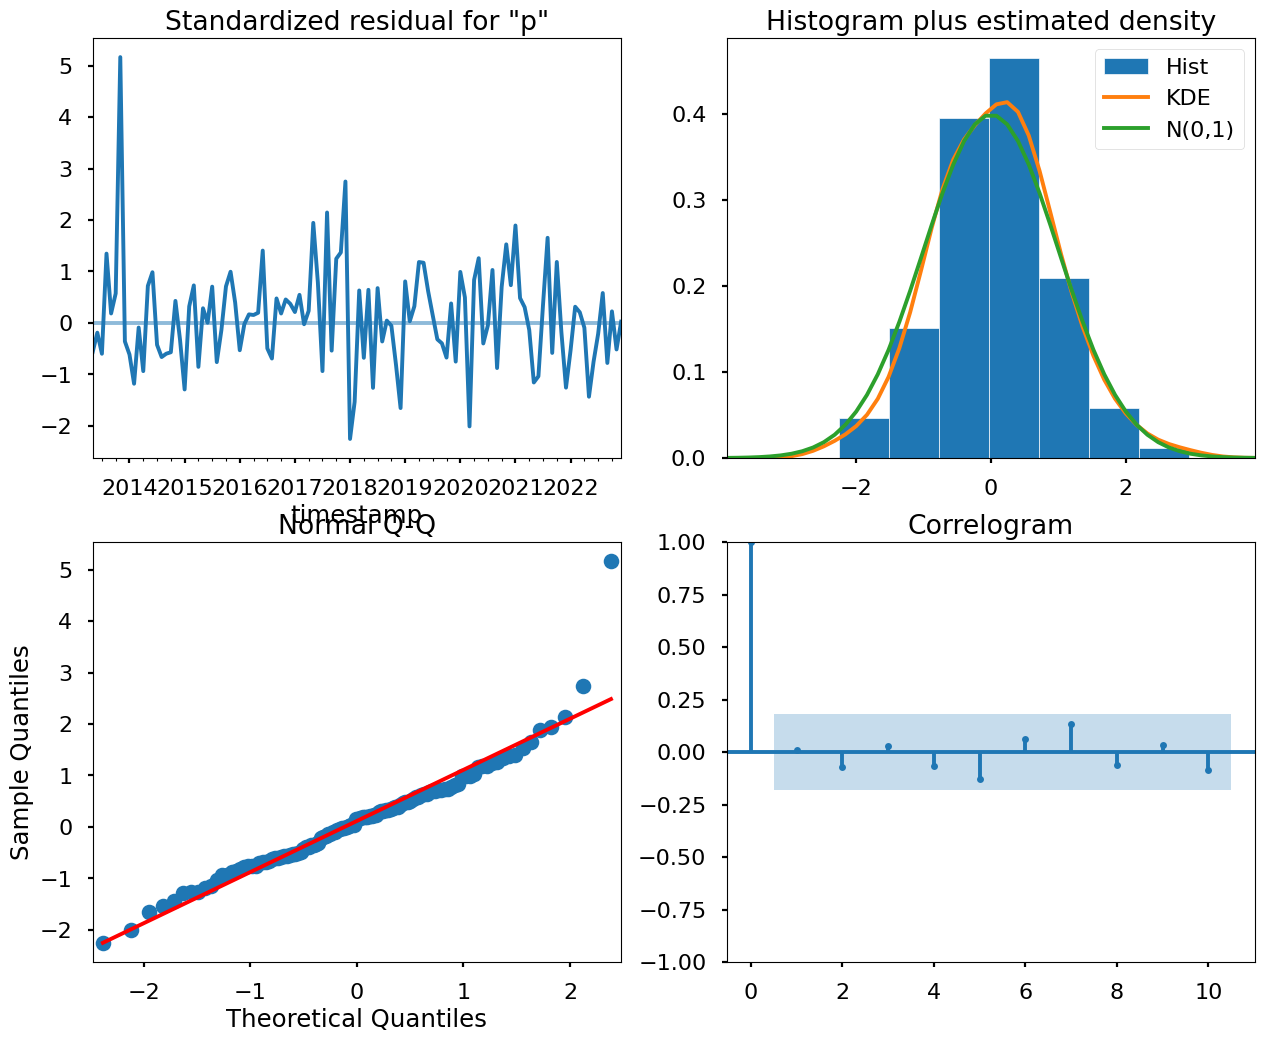

In [199]:
#show best model 1
best_model1.plot_diagnostics(figsize=(15, 12))
plt.show()

#### <font color=#DBFF33>Prediciton 1 </font>

In [210]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

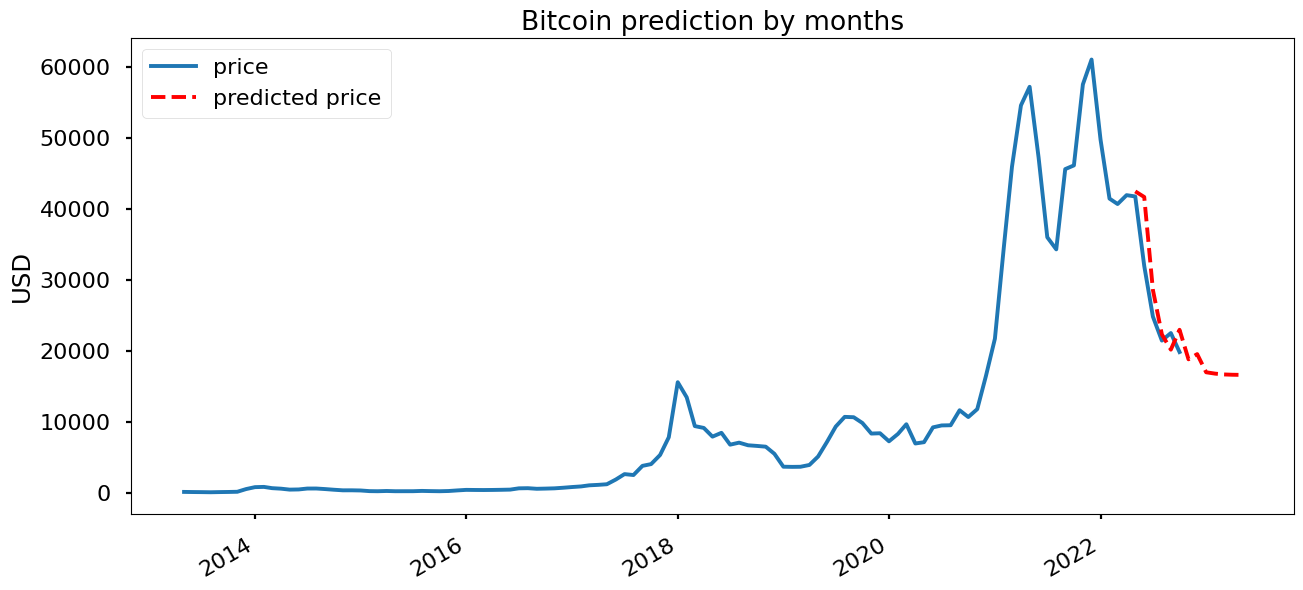

In [201]:
# Prediction Model 1
df_month1 = df_month[['price']]
date_list = [datetime(2022,9,30), 
            datetime(2022,10,31), 
            datetime(2022,11,30), 
            datetime(2022,12,31),
            datetime(2023,1,31),
            datetime(2023,2,28),
            datetime(2023,3,31),
            datetime(2023,4,30),
            ]

future1 = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month1 = pd.concat([df_month1, future1])

df_month1['forecast'] = invboxcox(best_model1.predict(start=datetime(2022,4,30),end=datetime(2023,5,31)), lmbda)

#show plot
plt.figure(figsize=(15,7))
df_month1.price.plot()
df_month1.forecast.plot(color='r', ls='--', label='predicted price')
plt.legend()
plt.title('Bitcoin prediction by months')
plt.ylabel('USD')
plt.show()

In [202]:
# show prediction price
print(df_month1['forecast'].tail())

2022-12-31    16972.822826
2023-01-31    16782.591222
2023-02-28    16671.620741
2023-03-31    16625.524060
2023-04-30    16606.325083
Name: forecast, dtype: float64


### <font color=#DBFF33>a) Model 2 </font>

SARIMAX It stands for Seasonal ARIMA with eXogenous regressors model.

In [203]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D = 1
d = 1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results2 = []
best_aic2 = float("inf")
warnings.filterwarnings('ignore')
for param2 in parameters_list:
    try:
        model2=SARIMAX(df_month.price_box, order=(param2[0], d, param2[1]), 
                                    seasonal_order=(param2[2], D, param2[3], 3)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param2)
        continue
    aic2 = model2.aic
    if aic2 < best_aic2:
        best_model2 = model2
        best_aic2 = aic2
        best_param2 = param2
    results2.append([param2, model2.aic])

In [204]:
# Best Models 2
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())
print(best_model2.summary())
print("dickey fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model2.resid[13:])[1])

      parameters        aic
19  (1, 0, 0, 1)  39.188456
13  (0, 2, 0, 1)  40.557049
37  (2, 0, 0, 1)  40.565705
25  (1, 1, 0, 1)  40.655044
7   (0, 1, 0, 1)  40.966851
                                      SARIMAX Results                                      
Dep. Variable:                           price_box   No. Observations:                  117
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 3)   Log Likelihood                 -16.594
Date:                             Mon, 05 Dec 2022   AIC                             39.188
Time:                                     04:59:08   BIC                             47.371
Sample:                                 04-30-2013   HQIC                            42.509
                                      - 12-31-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

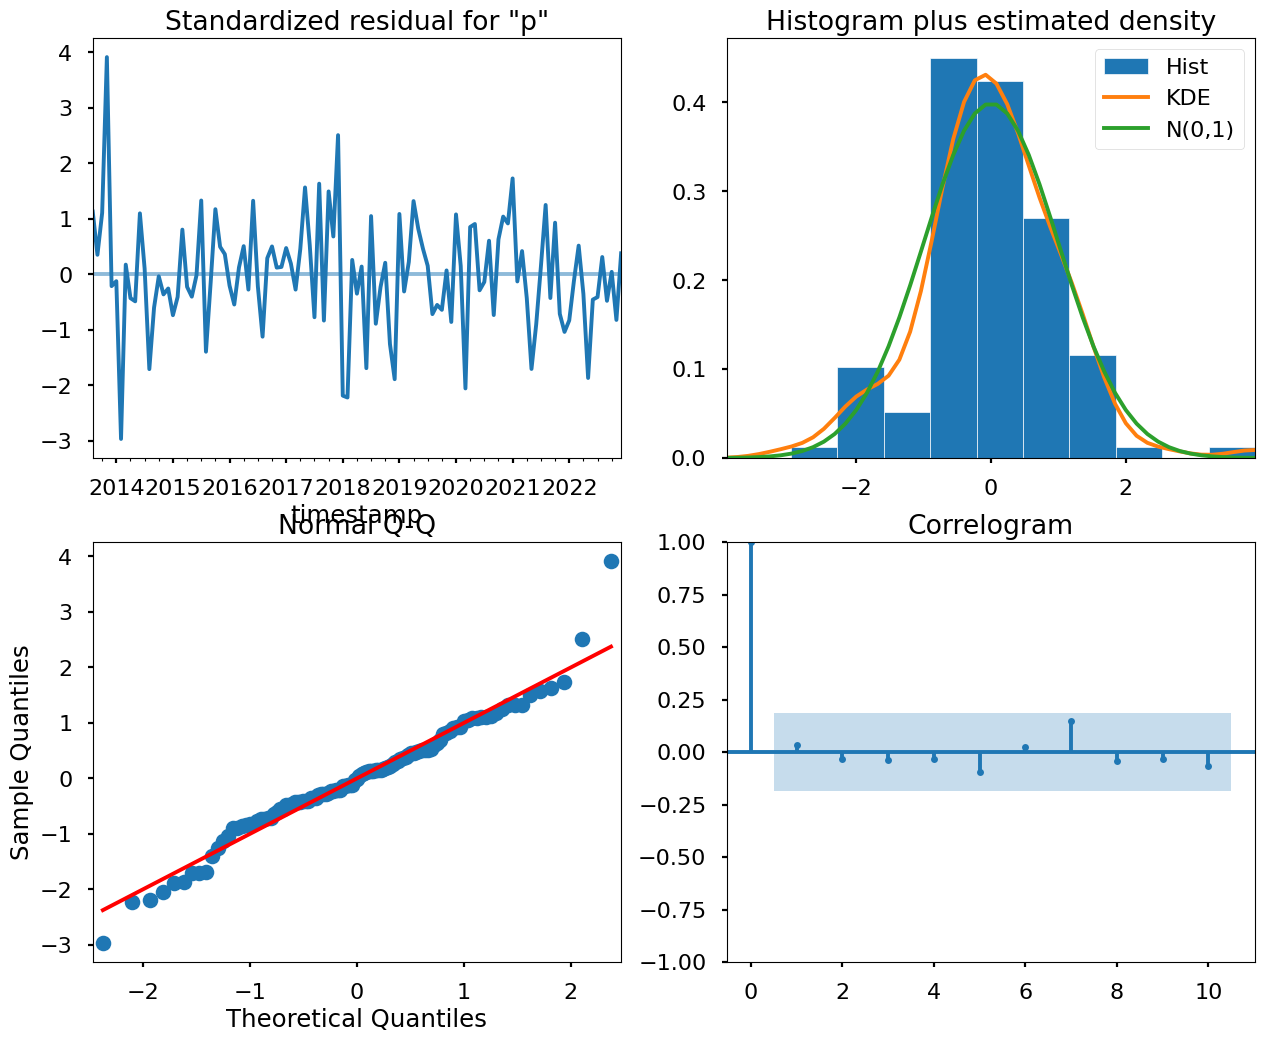

In [205]:
#show best model 2
best_model2.plot_diagnostics(figsize=(15, 12))
plt.show()

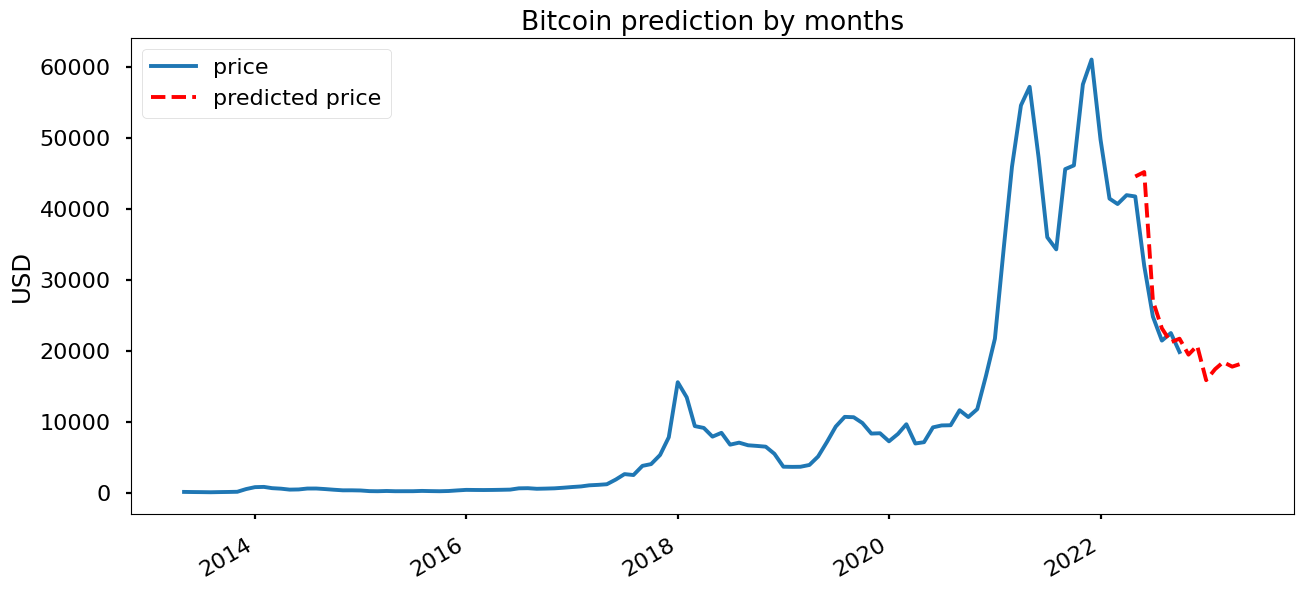

In [206]:
# Prediction Model 2
df_month2 = df_month[['price']]
date_list = [datetime(2022,9,30), 
            datetime(2022,10,31), 
            datetime(2022,11,30), 
            datetime(2022,12,31),
            datetime(2023,1,31),
            datetime(2023,2,28),
            datetime(2023,3,31),
            datetime(2023,4,30),
            ]

future2 = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future2])
df_month2['forecast'] = invboxcox(best_model2.predict(start=datetime(2022,4,30),end=datetime(2023,5,31)), lmbda)

#show plot
plt.figure(figsize=(15,7))
df_month2.price.plot()
df_month2.forecast.plot(color='r', ls='--', label='predicted price')
plt.legend()
plt.title('Bitcoin prediction by months')
plt.ylabel('USD')
plt.show()

In [211]:
# show prediction price with model 2
print(df_month2['forecast'].tail())

2022-12-31    15862.018320
2023-01-31    17414.144891
2023-02-28    18402.188599
2023-03-31    17767.235927
2023-04-30    18167.490080
Name: forecast, dtype: float64
